In [1]:
import numpy as np
import pandas as pd

In [2]:
import glob
import time

In [3]:
from nltk import ngrams
from nltk.tokenize import sent_tokenize
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [4]:
df = pd.read_csv("sqli.csv",encoding='utf-16')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=2, max_df=0.7, stop_words=stopwords.words('english'))
posts = vectorizer.fit_transform(df['Sentence'].values.astype('U')).toarray()

In [6]:
transformed_posts=pd.DataFrame(posts)

In [7]:
df=pd.concat([df,transformed_posts],axis=1)

In [8]:
X = df[df.columns[2:]]

In [9]:
y = df['Label']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier

In [14]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(20, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10,  activation='tanh'))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                94360     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              11264     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 110,955
Trainable params: 108,907
Non-trainable params: 2,048
______________________________________________

In [16]:
# DT
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

In [17]:
def accuracy_function(tp,tn,fp,fn):
    
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    return accuracy

def precision_function(tp,fp):
    
    precision = tp / (tp+fp)
    
    return precision

def recall_function(tp,fn):
    
    recall=tp / (tp+fn)
    
    return recall

def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for true,pred in zip(truth,predicted):
        
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
            
    accuracy = accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision = precision_function(true_positive, false_positive)
    recall = recall_function(true_positive, false_negative)
    print(" Confusion Matrix : \n tp : {0} \n tn : {1} \n fp: {2} \n fn : {3} ". format(true_positive, true_negative, false_positive, false_negative))
    
    return (accuracy,precision,recall)

In [18]:
accuracy,precision,recall=confusion_matrix(y_test,pred_dt)
F1 = (2 * recall * precision) / (recall + precision)
print(" For Decision Tree Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 Score : {3}".format(accuracy, precision, recall, F1))

 Confusion Matrix : 
 tp : 252 
 tn : 483 
 fp: 105 
 fn : 0 
 For Decision Tree Accuracy : 0.875 
 Precision : 0.7058823529411765 
 Recall : 1.0 
 F1 Score : 0.8275862068965517


<ipython-input-19-bfec23bfd8ad>:12: UserWarning: Legend does not support '0' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("0","1")


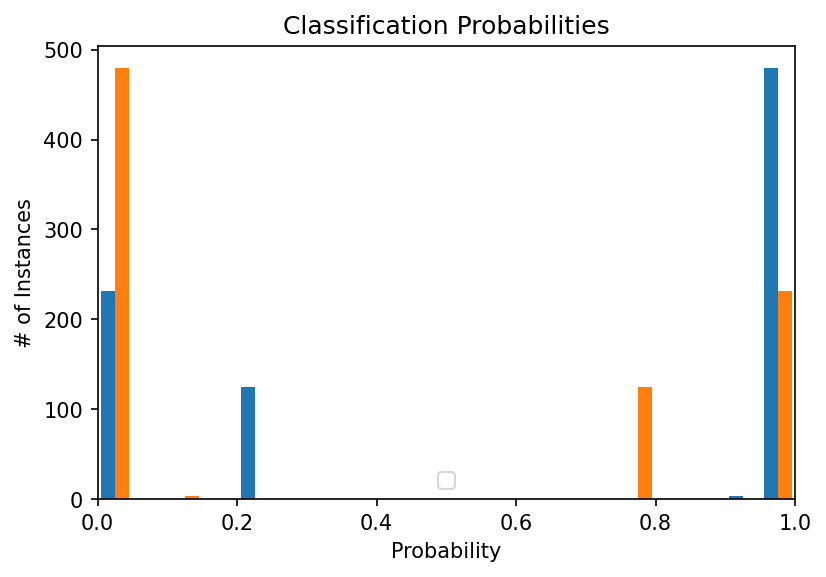

In [19]:
import matplotlib.pyplot as plt
#dt.predict_proba()
# get the probability distribution
probas = dt.predict_proba(X_test)
# plot
plt.figure(dpi=150)
plt.hist(probas, bins=20)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0, 1])
plt.legend("0","1")
plt.show()

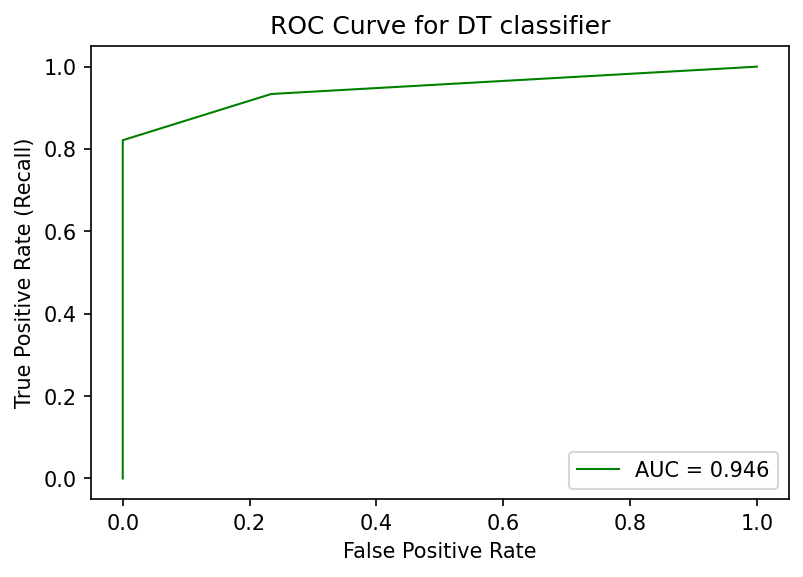

In [20]:
from sklearn.metrics import roc_curve, auc
# get false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, probas[:,0], pos_label=0)
# get area under the curve
roc_auc = auc(fpr, tpr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for DT classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

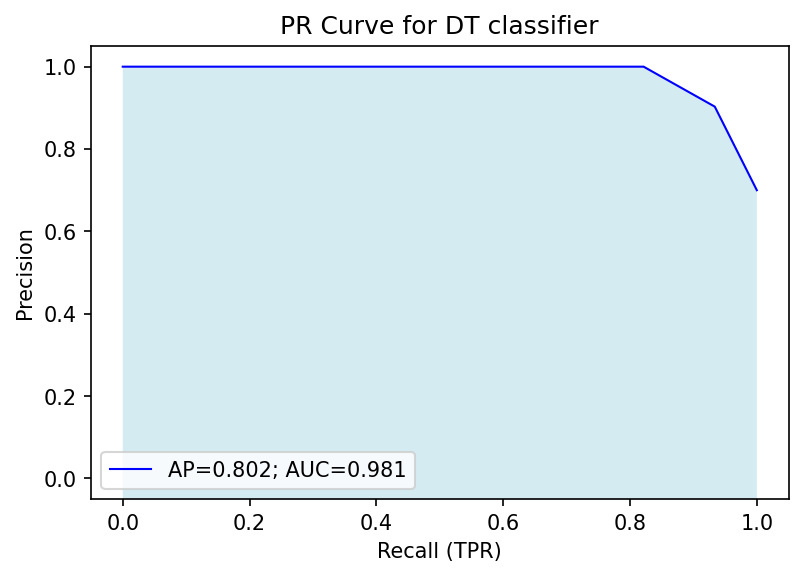

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
# get precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, probas[:,0], pos_label=0)
# average precision score
avg_precision = average_precision_score(y_test, probas[:,1])
# precision auc
pr_auc = auc(recall, precision)
# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for DT classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()